In [80]:
import pandas as pd
from mlforecast import MLForecast
from mlforecast.target_transforms import Differences
from mlforecast.utils import PredictionIntervals, generate_daily_series
from mlforecast.lag_transforms import ExpandingMean, RollingMean, RollingStd, RollingMax, RollingMin
from utilsforecast.plotting import plot_series
import plotly.graph_objects as go
from utilsforecast.losses import mape, mae, coverage, mase
from utilsforecast.evaluation import evaluate
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import shap 


# Função de formatação personalizada
def formato_brasileiro(valor):
    if pd.isna(valor):
        return ""
    # Formata com vírgula e depois troca por ponto
    return f"{valor:,.2f}".replace(",", ".")

# Configurar o pandas para usar esta formatação
pd.options.display.float_format = formato_brasileiro

## Lendo os dados

In [81]:
#https://www.kaggle.com/competitions/demand-forecasting-kernels-only/data?select=train.csv
df_01 = pd.read_csv("./data/train.csv")
df_01.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


## Transformando os dados

In [82]:
# Carregar os dados
df_02 = df_01[["date", "sales"]].copy()

# Converter a coluna Order Date para datetime com formato correto
df_02['date'] = pd.to_datetime(df_02['date'], format='%Y-%m-%d')

# Criar uma nova coluna com o mês-ano
df_02['Month'] = df_02['date'].dt.to_period('M')

# Agrupar por mês e somar as vendas
df_grouped = df_02.groupby('Month')['sales'].sum().reset_index()

# Renomear as colunas
df_grouped = df_grouped.rename(columns={'Month': 'ds', 'sales': 'y'})

# Converter Period para datetime (primeiro dia do mês)
df_grouped['ds'] = df_grouped['ds'].dt.to_timestamp()

# Mostrar resultado

print(f"\nShape: {df_grouped.shape}")


Shape: (60, 2)


In [83]:
df_grouped['unique_id'] = 'id_01'
df_grouped.tail(5)

,ds,y,unique_id
55,2017-08-01,1026403,id_01
56,2017-09-01,935263,id_01
57,2017-10-01,891160,id_01
58,2017-11-01,928837,id_01
59,2017-12-01,695170,id_01


In [84]:

# 1. Gerar o gráfico
fig = plot_series(
    df_grouped,
    engine='plotly',
    palette='Set2',
)

# 2. MODIFICAÇÃO PRINCIPAL: Mudar cor e grossura da LINHA ÚNICA
fig.data[0].line.color = '#2E5A88'  
fig.data[0].line.width = 2      

# Opcional: estilos adicionais
# fig.data[0].line.dash = 'solid'    # Sólida (padrão)
# fig.data[0].line.dash = 'dash'     # Tracejada
fig.data[0].line.shape = 'spline'  # Suavizada

# 3. Continuar com outras personalizações
fig.update_layout(
    title={
        'text': 'Análise da Série Temporal de Vendas',
        'x': 0.5,  # Centralizado horizontalmente
        'y': 0.95,  # Um pouco mais abaixo
        'font': {'size': 18, 'family': 'Arial'}  # Um pouco maior
    },
    yaxis_title='Volume de Vendas ($)',
    xaxis_title='Período',
    yaxis_tickformat=',.0f',
    yaxis_tickprefix='$ ',
    yaxis=dict(rangemode='tozero'),
    hovermode='x unified',
    plot_bgcolor='white',
    width=1200,
    height=400,
    # Melhorar legenda se houver
    showlegend=False  # Se tiver apenas uma linha, pode esconder a legenda
)

# 4. Personalizar o hover
fig.update_traces(
    hovertemplate='<b>Data:</b> %{x}<br>' +
                  '<b>Valor:</b> $ %{y:,.0f}<br>' +
                  '<extra></extra>'
)

# 5. Mostrar o gráfico
fig.show()

## Separar em treino e teste

In [85]:
# Separar os dados
df_treino = df_grouped[(df_grouped['ds'] >= '2013-01-01') & 
                       (df_grouped['ds'] <= '2017-06-01')].copy()

df_teste = df_grouped[df_grouped['ds'] > '2017-06-01'].copy()

In [86]:


models  = [
    CatBoostRegressor(n_estimators=200, random_state=42, verbose=False),
]
fcst = MLForecast(
    models=models,
    freq='MS',  # our serie has a monthly frequency
    lags=[12, 9, 6, 3, 1],
    
    lag_transforms={
        1: [
            ExpandingMean(),
            RollingMean(window_size=3),
            RollingMean(window_size=6),
            RollingMean(window_size=9),
            RollingMean(window_size=12),
            RollingStd(window_size=3),
            RollingMax(window_size=3),
            RollingMin(window_size=3),


        ],
        3: [
            ExpandingMean(),
        ],
    },
    #target_transforms=[Differences([1])], 
    date_features=['month', 'quarter'], 
)



In [87]:
# Fit the forecast model
df_train_prep = fcst.preprocess(df_treino)
df_train_prep.head()

,ds,y,unique_id,lag12,lag9,lag6,lag3,lag1,expanding_mean_lag1,rolling_mean_lag1_window_size3,rolling_mean_lag1_window_size6,rolling_mean_lag1_window_size9,rolling_mean_lag1_window_size12,rolling_std_lag1_window_size3,rolling_max_lag1_window_size3,rolling_min_lag1_window_size3,expanding_mean_lag3,month,quarter
12,2014-01-01,525.987.00,id_01,454.904.00,682.274.00,855.922.00,656.587.00,506.607.00,661.770.25,618.612.31,694.737.81,712.171.12,661.770.25,98.660.66,692.643.00,506.607.00,674.199.31,1,1
13,2014-02-01,529.117.00,id_01,459.417.00,763.242.00,766.761.00,692.643.00,525.987.00,651.325.38,575.079.00,639.748.69,694.805.88,667.693.81,102.273.59,692.643.00,506.607.00,675.876.00,2,1
14,2014-03-01,704.301.00,id_01,617.382.00,795.597.00,689.907.00,506.607.00,529.117.00,642.596.19,520.570.34,600.141.31,668.792.00,673.502.19,12.194.44,529.117.00,506.607.00,661.770.25,3,1
15,2014-04-01,788.914.00,id_01,682.274.00,855.922.00,656.587.00,525.987.00,704.301.00,646.709.88,586.468.31,602.540.31,658.648.00,680.745.44,102.058.17,704.301.00,525.987.00,651.325.38,4,2
16,2014-05-01,882.877.00,id_01,763.242.00,766.761.00,692.643.00,529.117.00,788.914.00,655.597.62,674.110.69,624.594.81,651.202.69,689.632.06,132.503.67,788.914.00,529.117.00,642.596.19,5,2


In [88]:
fcst.fit(
    df_treino,
    # https://nixtlaverse.nixtla.io/mlforecast/docs/how-to-guides/prediction_intervals.html
    prediction_intervals=PredictionIntervals(n_windows=3, h=6, method="conformal_distribution")
)

MLForecast(models=[CatBoostRegressor], freq=MS, lag_features=['lag12', 'lag9', 'lag6', 'lag3', 'lag1', 'expanding_mean_lag1', 'rolling_mean_lag1_window_size3', 'rolling_mean_lag1_window_size6', 'rolling_mean_lag1_window_size9', 'rolling_mean_lag1_window_size12', 'rolling_std_lag1_window_size3', 'rolling_max_lag1_window_size3', 'rolling_min_lag1_window_size3', 'expanding_mean_lag3'], date_features=['month', 'quarter'], num_threads=1)

In [89]:
df_train_prep, _ = fcst.preprocess(df_treino, return_X_y=True)
df_train_prep.head()

,lag12,lag9,lag6,lag3,lag1,expanding_mean_lag1,rolling_mean_lag1_window_size3,rolling_mean_lag1_window_size6,rolling_mean_lag1_window_size9,rolling_mean_lag1_window_size12,rolling_std_lag1_window_size3,rolling_max_lag1_window_size3,rolling_min_lag1_window_size3,expanding_mean_lag3,month,quarter
12,454.904.00,682.274.00,855.922.00,656.587.00,506.607.00,661.770.25,618.612.31,694.737.81,712.171.12,661.770.25,98.660.66,692.643.00,506.607.00,674.199.31,1,1
13,459.417.00,763.242.00,766.761.00,692.643.00,525.987.00,651.325.38,575.079.00,639.748.69,694.805.88,667.693.81,102.273.59,692.643.00,506.607.00,675.876.00,2,1
14,617.382.00,795.597.00,689.907.00,506.607.00,529.117.00,642.596.19,520.570.34,600.141.31,668.792.00,673.502.19,12.194.44,529.117.00,506.607.00,661.770.25,3,1
15,682.274.00,855.922.00,656.587.00,525.987.00,704.301.00,646.709.88,586.468.31,602.540.31,658.648.00,680.745.44,102.058.17,704.301.00,525.987.00,651.325.38,4,2
16,763.242.00,766.761.00,692.643.00,529.117.00,788.914.00,655.597.62,674.110.69,624.594.81,651.202.69,689.632.06,132.503.67,788.914.00,529.117.00,642.596.19,5,2


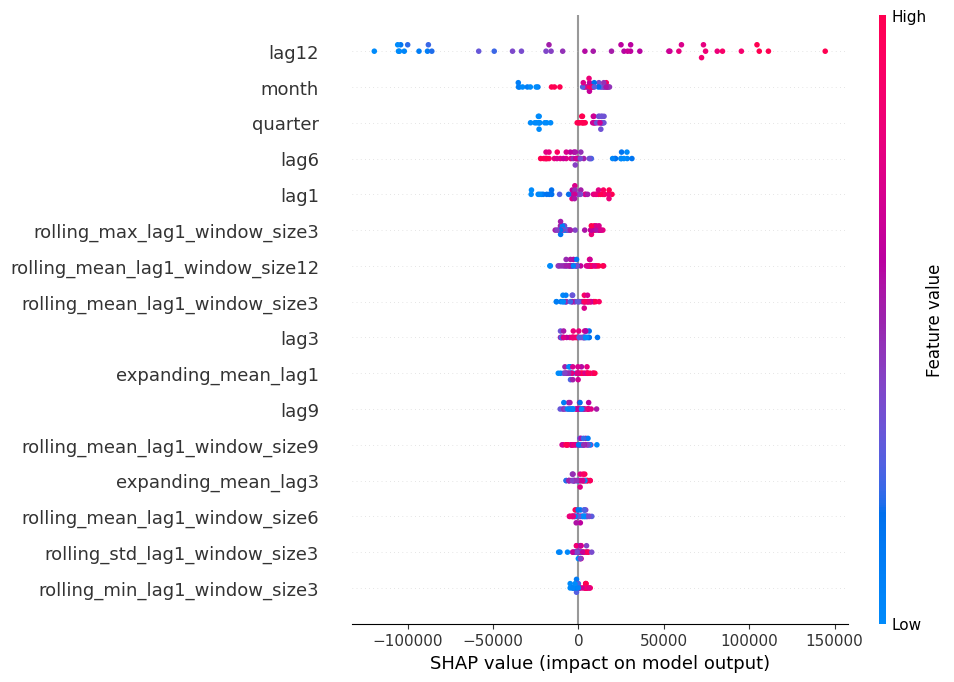

In [90]:

# pre-proc the df_train
df_train_prep, _ = fcst.preprocess(df_treino, return_X_y=True)

# Get the catboost model
model = fcst.models_['CatBoostRegressor']

# Getting the SHAP values from the LGBM model
explainer = shap.TreeExplainer(model)
shap_values = explainer(df_train_prep)
shap.plots.beeswarm(shap_values, max_display=25)



## Aplicar no teste

In [91]:
# Realizamos o merge dos forecasts com o DataFrame de teste usando as colunas 'unique_id' e 'ds'.

levels = [90, 95]
predictions = fcst.predict(6, level=levels, X_df=df_teste)
predictions

,unique_id,ds,CatBoostRegressor,CatBoostRegressor-lo-95,CatBoostRegressor-lo-90,CatBoostRegressor-hi-90,CatBoostRegressor-hi-95
0,id_01,2017-07-01,1.045.656.40,837.855.76,856.058.19,1.235.254.61,1.253.457.04
1,id_01,2017-08-01,980.091.71,877.995.61,883.470.95,1.076.712.48,1.082.187.81
2,id_01,2017-09-01,920.874.68,859.550.80,862.054.03,979.695.34,982.198.56
3,id_01,2017-10-01,890.236.10,793.535.38,798.834.78,981.637.41,986.936.82
4,id_01,2017-11-01,878.288.70,716.571.15,721.904.39,1.034.673.02,1.040.006.26
5,id_01,2017-12-01,731.922.66,549.402.74,560.606.25,903.239.07,914.442.58


In [92]:
from utilsforecast.plotting import plot_series
import plotly.graph_objects as go

# Merge the test dateset with all predictions
test_df_final = df_teste.merge(predictions, how='left', on=['unique_id', 'ds'])

# Gráfico base com histórico + previsão + intervalo
fig = plot_series(
    test_df_final, 
    test_df_final, 
    plot_random=False, 
    level=[90],
    engine='plotly'
)

# ─────────────────────────────────────────────
# 🎨 Estilo das séries
# ─────────────────────────────────────────────

# Série histórica (primeiro trace)
fig.data[0].line.color = '#2E5A88'
fig.data[0].line.width = 2
fig.data[0].line.shape = 'spline'
fig.data[0].name = 'Histórico'

# Previsão (normalmente o segundo trace)
fig.data[1].line.color = '#E76F51'
fig.data[1].line.width = 2
fig.data[1].line.dash = 'dash'
fig.data[1].mode = 'lines+markers'
fig.data[1].marker.size = 6
fig.data[1].name = 'Previsão'

# Intervalo de confiança (90%)
# Ajuste fino das cores do intervalo
if len(fig.data) >= 4:
    fig.data[2].fillcolor = 'rgba(231,111,81,0.25)'  # faixa superior
    fig.data[3].fillcolor = 'rgba(231,111,81,0.15)'  # faixa inferior
    fig.data[3].name = 'Intervalo 90%'

# ─────────────────────────────────────────────
# 🖼️ Layout no mesmo padrão do segundo gráfico
# ─────────────────────────────────────────────
fig.update_layout(
    title={
        'text': 'Histórico + Previsão de Vendas',
        'x': 0.5,
        'y': 0.95,
        'font': {'size': 18, 'family': 'Arial'}
    },
    yaxis_title='Volume de Vendas ($)',
    xaxis_title='Período',
    yaxis_tickformat=',.0f',
    yaxis_tickprefix='$ ',
    yaxis=dict(rangemode='tozero'),
    hovermode='x unified',
    plot_bgcolor='white',
    width=1200,
    height=400,
    showlegend=True
)

# ─────────────────────────────────────────────
# 🧾 Hover customizado
# ─────────────────────────────────────────────
fig.update_traces(
    hovertemplate='<b>Data:</b> %{x}<br>' +
                  '<b>Valor:</b> $ %{y:,.0f}<br>' +
                  '<extra></extra>'
)

fig.show()


In [ ]:
## Avaliação do modelo
metrics = [
    mape,
    mae,
    coverage
]

results = evaluate(test_df_final, metrics, level=[90])
results

,unique_id,metric,CatBoostRegressor
0,id_01,mape,0.05
1,id_01,mae,45.776.84
2,id_01,coverage_level90,1.00


In [94]:
test_df_final

,ds,y,unique_id,CatBoostRegressor,CatBoostRegressor-lo-95,CatBoostRegressor-lo-90,CatBoostRegressor-hi-90,CatBoostRegressor-hi-95
0,2017-07-01,1171393,id_01,1.045.656.40,837.855.76,856.058.19,1.235.254.61,1.253.457.04
1,2017-08-01,1026403,id_01,980.091.71,877.995.61,883.470.95,1.076.712.48,1.082.187.81
2,2017-09-01,935263,id_01,920.874.68,859.550.80,862.054.03,979.695.34,982.198.56
3,2017-10-01,891160,id_01,890.236.10,793.535.38,798.834.78,981.637.41,986.936.82
4,2017-11-01,928837,id_01,878.288.70,716.571.15,721.904.39,1.034.673.02,1.040.006.26
5,2017-12-01,695170,id_01,731.922.66,549.402.74,560.606.25,903.239.07,914.442.58


## Reajustar o modelo para predizer uma janela de 6 meses frente ao histórico

In [95]:
# Reajusta o modelo com TODO o histórico disponível
fcst.fit(
    df_grouped,
    prediction_intervals=PredictionIntervals(n_windows=3, h=6, method="conformal_distribution")
)

levels = [90, 95]

horizonte = 6
future_forecast = fcst.predict(h=horizonte, level=levels)

future_forecast


,unique_id,ds,CatBoostRegressor,CatBoostRegressor-lo-95,CatBoostRegressor-lo-90,CatBoostRegressor-hi-90,CatBoostRegressor-hi-95
0,id_01,2018-01-01,691.942.53,421.527.90,432.231.45,951.653.61,962.357.16
1,id_01,2018-02-01,677.802.30,543.161.18,550.632.40,804.972.20,812.443.42
2,id_01,2018-03-01,840.948.46,763.962.62,767.013.10,914.883.82,917.934.31
3,id_01,2018-04-01,951.563.06,881.373.11,882.647.94,1.020.478.18,1.021.753.01
4,id_01,2018-05-01,1.001.025.33,898.458.90,899.768.09,1.102.282.57,1.103.591.76
5,id_01,2018-06-01,1.060.788.40,974.265.63,982.474.67,1.139.102.13,1.147.311.18


In [98]:
from utilsforecast.plotting import plot_series
import plotly.graph_objects as go

model_col = 'CatBoostRegressor'

# 1. Gráfico do histórico
fig = plot_series(
    df_grouped,
    engine='plotly',
    palette='Set2',
)

# Estilo da série histórica
fig.data[0].line.color = '#2E5A88'
fig.data[0].line.width = 2
fig.data[0].line.shape = 'spline'

# 2. Adicionar linha de previsão futura
fig.add_trace(
    go.Scatter(
        x=future_forecast['ds'],
        y=future_forecast[model_col],
        mode='lines+markers',
        name='Previsão',
        line=dict(color='#E76F51', width=2, dash='dash'),
        marker=dict(size=6),
    )
)

# 3. (Opcional) Intervalos de previsão
fig.add_trace(
    go.Scatter(
        x=future_forecast['ds'],
        y=future_forecast[f'{model_col}-hi-90'],
        mode='lines',
        line=dict(width=0),
        showlegend=False,
        hoverinfo='skip'
    )
)

fig.add_trace(
    go.Scatter(
        x=future_forecast['ds'],
        y=future_forecast[f'{model_col}-lo-90'],
        mode='lines',
        line=dict(width=0),
        fill='tonexty',
        fillcolor='rgba(231,111,81,0.2)',
        name='Intervalo 90%',
        hoverinfo='skip'
    )
)

# 4. Layout e estilo
fig.update_layout(
    title={
        'text': 'Histórico + Previsão de Vendas (6 meses à frente)',
        'x': 0.5,
        'y': 0.95,
        'font': {'size': 18, 'family': 'Arial'}
    },
    yaxis_title='Volume de Vendas ($)',
    xaxis_title='Período',
    yaxis_tickformat=',.0f',
    yaxis_tickprefix='$ ',
    yaxis=dict(rangemode='tozero'),
    hovermode='x unified',
    plot_bgcolor='white',
    width=1200,
    height=400,
    showlegend=True
)

# 5. Hover customizado
fig.update_traces(
    hovertemplate='<b>Data:</b> %{x}<br>' +
                  '<b>Valor:</b> $ %{y:,.0f}<br>' +
                  '<extra></extra>'
)

fig.show()
